In [1]:
import numpy as np
import torch
import torch.nn as nn

from IPython.display import clear_output

from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

In [2]:
# nets
from autoencoders import StackedAutoEncoder, StackedDenoisingAutoEncoder
from deepclustering import DEC, IDEC, IDEC_loss
from utils import cluster_acc, predict_cluster_accuracy # hungarian algorithm

# dataset&train_cycles
from train_val import train, evaluate

# visualization
from visualization import plot_stats, plot_stats_dec, plot_stats_idec


In [3]:
class EmbeddingsDataset(Dataset):
    def __init__(self, features, text, labels, train):
        assert len(features) == len(text) == len(labels)
        # self.features = features
        self.labels = labels.tolist()
        self.text = text


        embeddings_ds = TensorDataset(
            features, 
            labels
        ) 
        train_idx, val_idx = train_test_split(
            list(range(len(embeddings_ds))), test_size=.1, shuffle=True
        )
        if train == -1:
            self.ds = embeddings_ds
        else:
            self.ds = Subset(embeddings_ds, train_idx) if train else Subset(embeddings_ds, val_idx)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index):
        data = self.ds[index][0]
        _class = self.ds[index][1]
        return (data, _class)

    def get_text_by_labels(self, lbl):
        _dict = {self.labels[i]: self.text[i] for i in range(len(self.labels))}

        return np.vectorize(_dict.get)(lbl) if isinstance(lbl, (list, np.ndarray)) else _dict[lbl]



In [4]:
txt_labels = np.load('../bert_embeddings/emb_txt_labels.npy', allow_pickle=True)

num_labels = torch.Tensor(
    np.load('../bert_embeddings/emb_num_labels.npy')
)

embdict = np.load('../bert_embeddings/embdict.npy', allow_pickle=True).item()
embeddings = torch.Tensor(embdict['max_pooling__identity']) # take 'max_pooling__identity' as default example

In [5]:
train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)
static_loader =  DataLoader(train_dataset, batch_size=256, pin_memory=False, shuffle=False)

## Train&Valid cycle

In [6]:
def whole_train_valid_cycle(
    model, scheduler, optimizer, loss_fn, device, title,
    num_epochs:int = 100,
    patience_threshold:tuple = None,
    save_best_params_as:str = None
):
    train_loss_history, valid_loss_history = [], []
    
    best_valid_loss = np.inf
    patience = 0

    train_acc_history, train_nmi_history, train_ari_history = [], [], []
    val_acc_history, val_nmi_history, val_ari_history = [], [], []
    
    if type(model) == IDEC:
        train_rec_loss_history, train_cl_loss_history = [], []

    for epoch in range(num_epochs):

        if isinstance(model, DEC):

            train_loss, train_y, train_y_pred, = train(model, train_loader, optimizer, loss_fn, device, static_loader)
            valid_loss, val_targets, val_predicted = evaluate(model, valid_loader, loss_fn, device)
            
            if type(model) == IDEC:

                train_rec_loss, train_cl_loss = train_loss['rec'], train_loss['clust']
                train_loss = train_loss['total']
                
                
                train_rec_loss_history.append(train_rec_loss)
                train_cl_loss_history.append(train_cl_loss)
                

            train_acc = cluster_acc(train_y, train_y_pred)
            train_nmi = normalized_mutual_info_score(train_y, train_y_pred)
            train_ari = adjusted_rand_score(train_y, train_y_pred)

            train_acc_history.append(train_acc)
            train_nmi_history.append(train_nmi)
            train_ari_history.append(train_ari)

            val_acc = cluster_acc(val_targets, val_predicted)
            val_nmi = normalized_mutual_info_score(val_targets, val_predicted)
            val_ari = adjusted_rand_score(val_targets, val_predicted)

            val_acc_history.append(val_acc)
            val_nmi_history.append(val_nmi)
            val_ari_history.append(val_ari)
        
 
        elif isinstance(model, StackedAutoEncoder):
            train_loss = train(model, train_loader, optimizer, loss_fn, device)
            valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        print('patience:', patience)
        if patience_threshold == None:
            pass
        elif patience_threshold[0] is not None and len(valid_loss_history)>1:
            if round(valid_loss_history[-2], patience_threshold[1]) \
            == round(valid_loss, patience_threshold[1]):
                patience += 1
            else:
                patience = 0

            if patience == patience_threshold[0]:
                print('Training stopped. Patience threshold was reached')
                break
        else:
            pass


        clear_output(wait=True)
        

        if isinstance(model, DEC):
            if type(model) == DEC:
                plot_stats_dec(
                    train_loss_history, valid_loss_history, 
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )
            if type(model) == IDEC:
                plot_stats_idec(
                    train_loss_history, valid_loss_history, 
                    train_rec_loss_history, 
                    train_cl_loss_history,
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )

        elif isinstance(model, StackedAutoEncoder):
            plot_stats(
                train_loss_history, valid_loss_history,
                title
            )

            # scheduler only for autoencoder
            scheduler.step() if not scheduler == None else None


        if not save_best_params_as == None:
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), save_best_params_as)
                print(f"Model parameters saved to '{save_best_params_as}'")                  
        
        

## Initialize

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce GTX 1060 with Max-Q Design


### Getting baseline KMeans score

In [8]:
km_baseline = KMeans(n_clusters=7, random_state=0, n_init=20).fit_predict(embeddings)

cluster_acc(
    num_labels.numpy(),
    km_baseline
)

0.544923821728606

## Run Autoencoder for every type of embedding

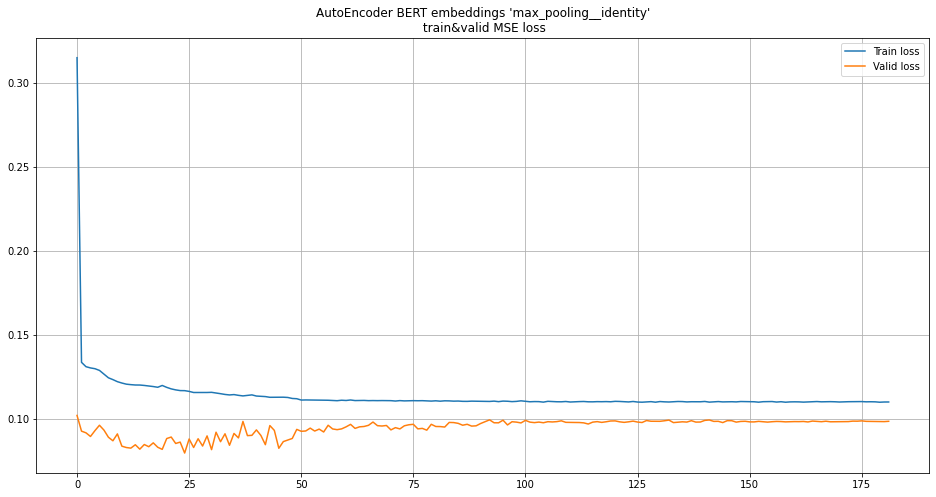

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 45.80it/s]

patience: 9
Training stopped. Patience threshold was reached


In [17]:
# initialize model with parameters described in Subakti et al. (2022)
loss_fn = nn.MSELoss()
model = StackedDenoisingAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.05)

optimizer = Adam(model.parameters(), lr=1e-3, )
# optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=.1) 

torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    scheduler,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10,3),
    # save_best_params_as = './ae_weights/bertemb_train_1.pt',
    title="AutoEncoder BERT embeddings 'max_pooling__identity'\n train&valid MSE"
)

## Run DEC

#### num. 1 'max_pooling__standard'

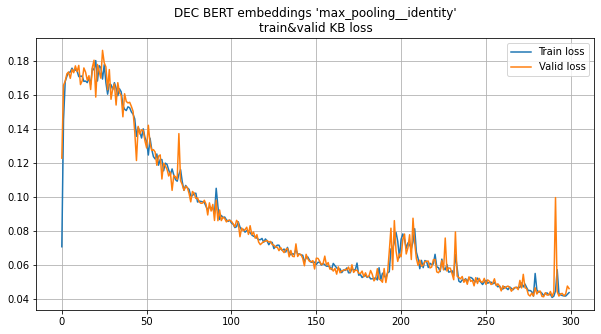

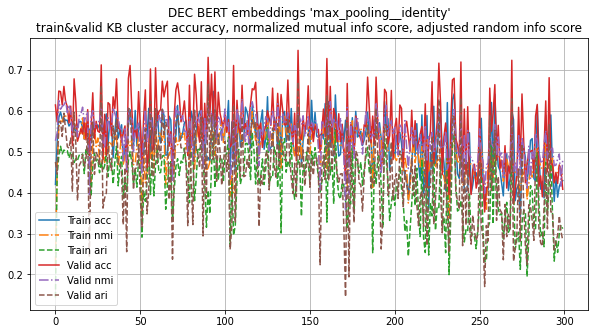

In [26]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_1.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-3)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=60, gamma=0.01)

whole_train_valid_cycle(
    dec,
    scheduler,
    optimizer,
    loss_fn,
    num_epochs = 300,
    patience_threshold=(10,3),
    device = device,
    # save_best_params_as='./weights/bertemb_dec_weights_1.pt',
    title="DEC BERT embeddings 'max_pooling__identity'\ntrain&valid KL"
)


In [27]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.5200949367088608 0.39142816460202196


*Awful plots & performance! Let's start with another set of hyperparameters*

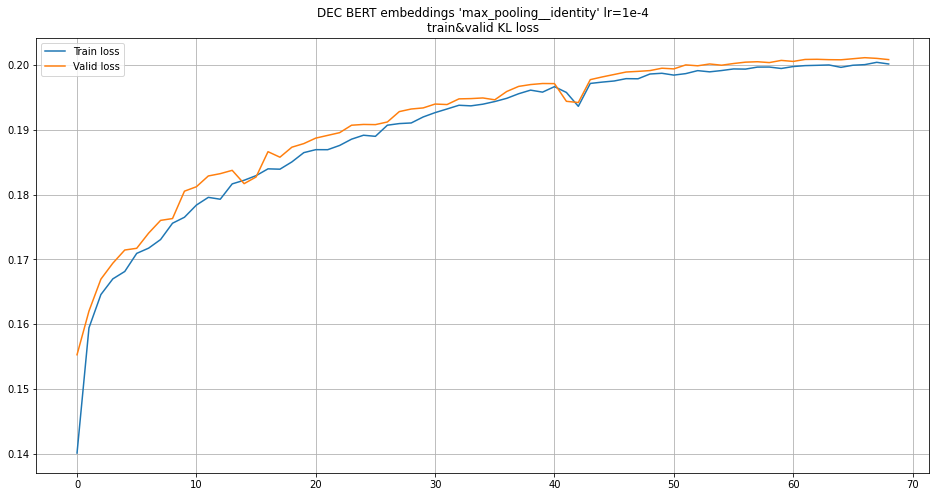

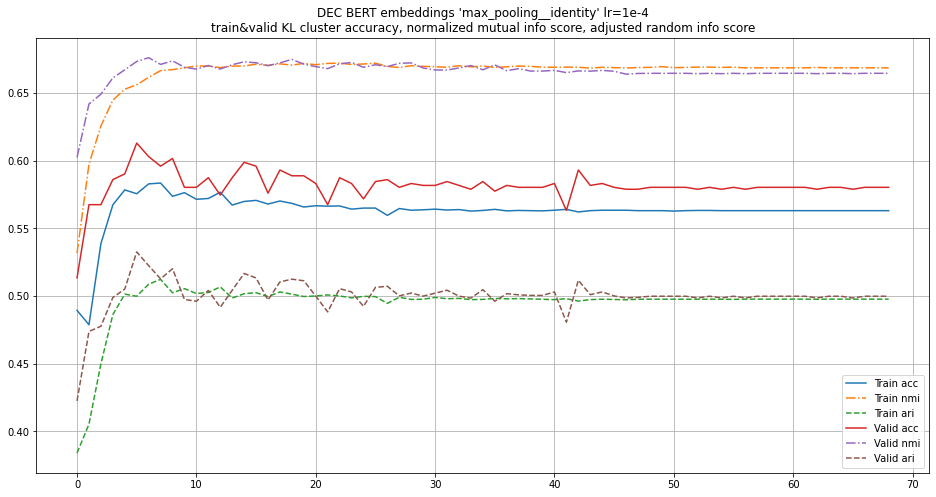

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 68.78it/s]

patience: 9
Training stopped. Patience threshold was reached


In [19]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_1.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.01)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    patience_threshold=(10,3),
    device = device,
    save_best_params_as='./weights/bertemb_dec_weights_1',
    title="DEC BERT embeddings 'max_pooling__identity' lr=1e-4\ntrain&valid KL"
)


In [20]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.5537974683544303 0.5655702691157625


*Still awful. But encoder outputs seem to catch KMeans baseline score.
What about normalized embeddings?*

### Lets continue our findings with normalized embeddings!

#### num. 2 'max_pooling__standard'

In [9]:
embeddings = torch.Tensor(embdict['max_pooling__standard'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

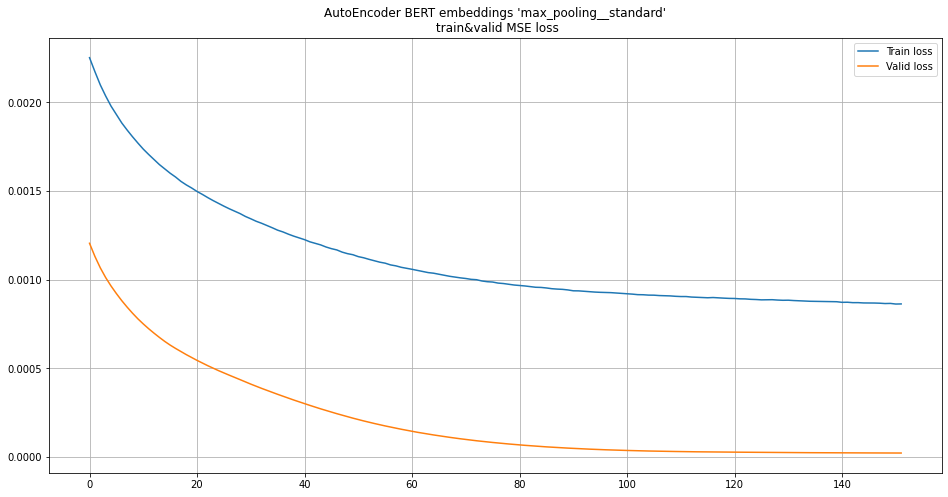

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 64.14it/s]

patience: 9
Training stopped. Patience threshold was reached


In [11]:
loss_fn = nn.MSELoss()
model = StackedDenoisingAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

optimizer = Adam(model.parameters(), lr=1e-6, )
scheduler = StepLR(optimizer, step_size=100, gamma=.1) # 60~=20000/256

# torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 6),
    # save_best_params_as = r'ae_weights/bertemb_train_2.pt',
    title="AutoEncoder BERT embeddings 'max_pooling__standard'\n train&valid MSE"
)

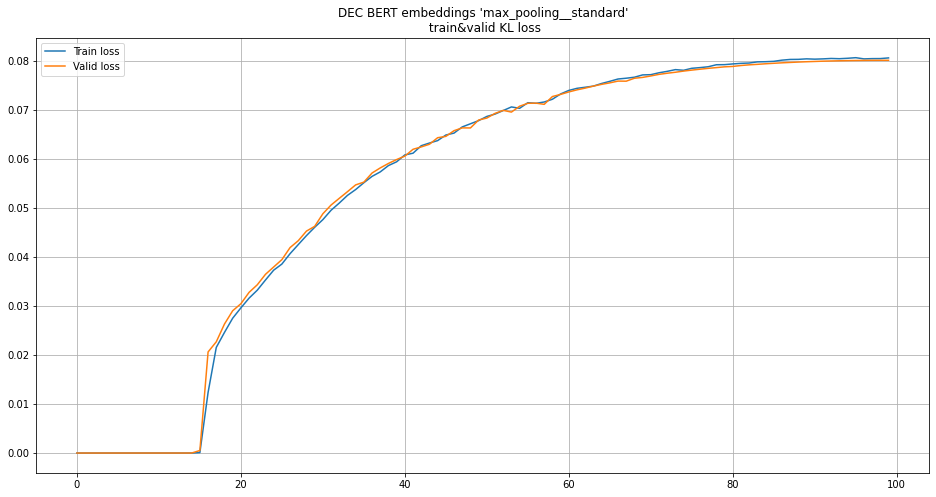

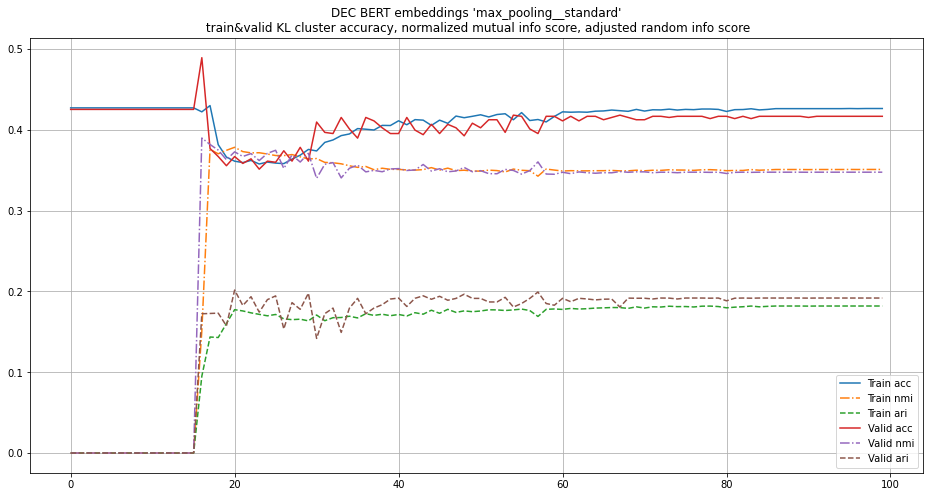

In [13]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_2.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    # patience_threshold = (10,2),
    device = device,
    # save_best_params_as= r'./weights/bertemb_dec_weights_2.pt',
    title="DEC BERT embeddings 'max_pooling__standard'\n train&valid KL"
)


In [14]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.22737341772151898 0.42787982343727754


*Despite contrintuitive behavior of loss curve, algoritm managed to find stable solution.*

#### num. 3 'max_pooling__layer'

In [15]:
embeddings = torch.Tensor(embdict['max_pooling__layer'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

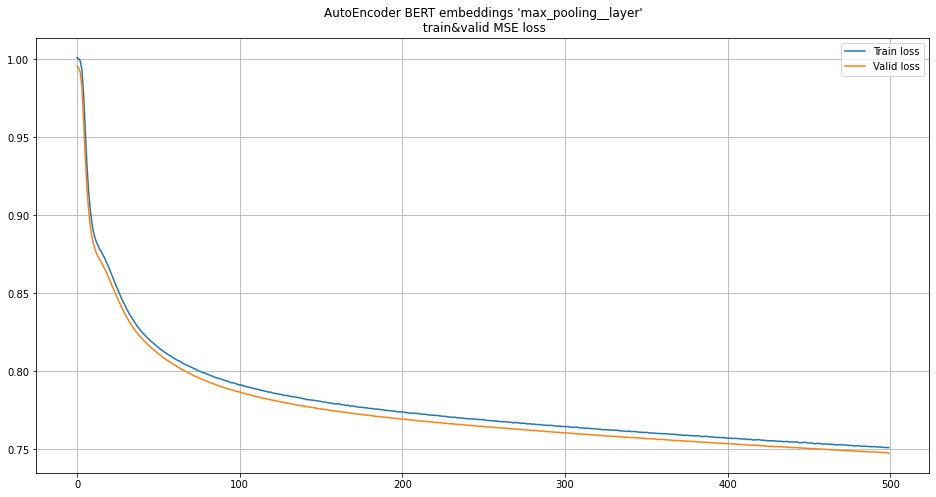

In [19]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

optimizer = Adam(model.parameters(), lr=1e-5, )
# scheduler = StepLR(optimizer, step_size=100, gamma=.1) # 60~=20000/256

# torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 4),
    # save_best_params_as = './ae_weights/bertemb_train_3.pt',
    title="AutoEncoder BERT embeddings 'max_pooling__layer'\n train&valid MSE"
)

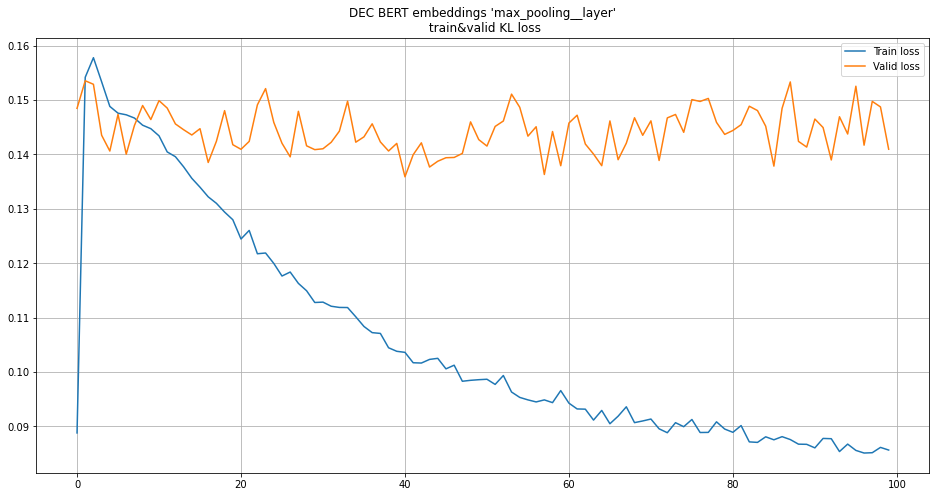

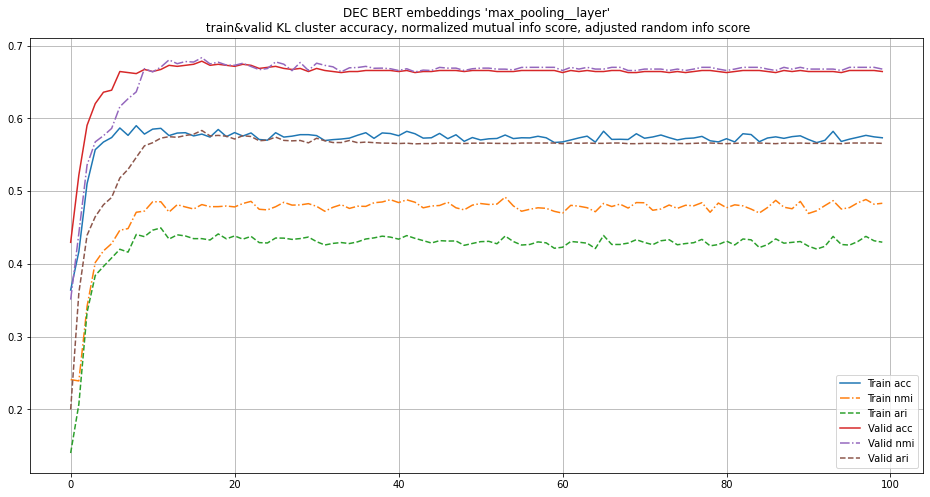

In [23]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.1)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_3.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    patience_threshold=(10,2),
    device = device,
    # save_best_params_as='./weights/bertemb_dec_weights_3.pt',
    title="DEC BERT embeddings 'max_pooling__layer'\n train&valid KL"
)


In [26]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.5363924050632911 0.6539940196497224


Looks much better than standard normalization. Adding dropout raises chances of stable performance. Still not really understand how validation loss behaves. Maybe the problem is with the size of validation dataset

*Note: 'standard' normalization uses Denoising autoencoder, while 'layer' allowing stable performance. Anyway, final performance may vary +-5% because of good random seeds despite the learning curve behavior*

#### num. 4 'max_pooling__minmax'

In [139]:
embeddings = torch.Tensor(embdict['max_pooling__minmax'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

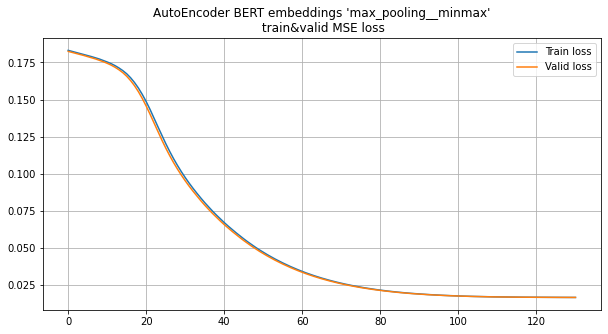

Model parameters saved to './ae_weights/bertemb_train_4.pt'


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 46.48it/s]

patience: 9
Training stopped. Patience threshold was reached
Fin train loss: 0.01645738333463669
Fin valid loss: 0.016458477824926376


In [141]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

optimizer = Adam(model.parameters(), lr=1e-6, )
scheduler = StepLR(optimizer, step_size=100, gamma=.1) # 60~=20000/256

# torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 4),
    # save_best_params_as = './ae_weights/bertemb_train_4.pt',
    title="AutoEncoder BERT embeddings 'max_pooling__minmax'\n train&valid MSE"
)

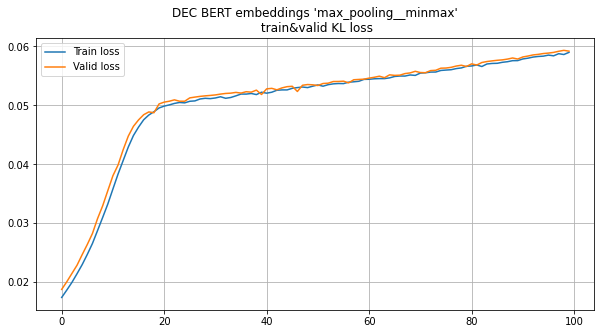

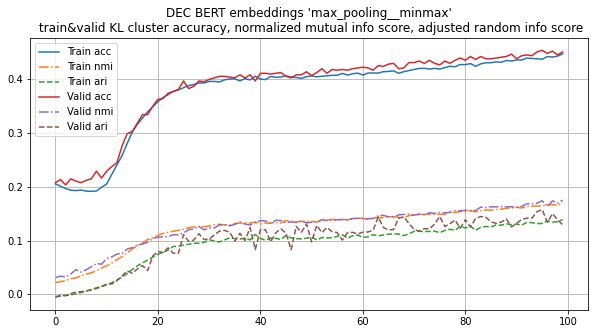

In [152]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_4.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-5)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    # patience_threshold=(10,3),
    device = device,
    # save_best_params_as='./weights/bertemb_dec_weights_4.pt',
    title="DEC BERT embeddings 'max_pooling__minmax'\n train&valid KL"
)


In [153]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.2060126582278481 0.43984052399259577


*Bad initial guess despite smooth learning curve. Bad performance.*

#### num. 5 'mean_pooling__standard'

*Note: we skip 'mean_pooling__identity' and 'mean_pooling__minmax' due to they bad performance*

In [34]:
embeddings = torch.Tensor(embdict['mean_pooling__standard'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

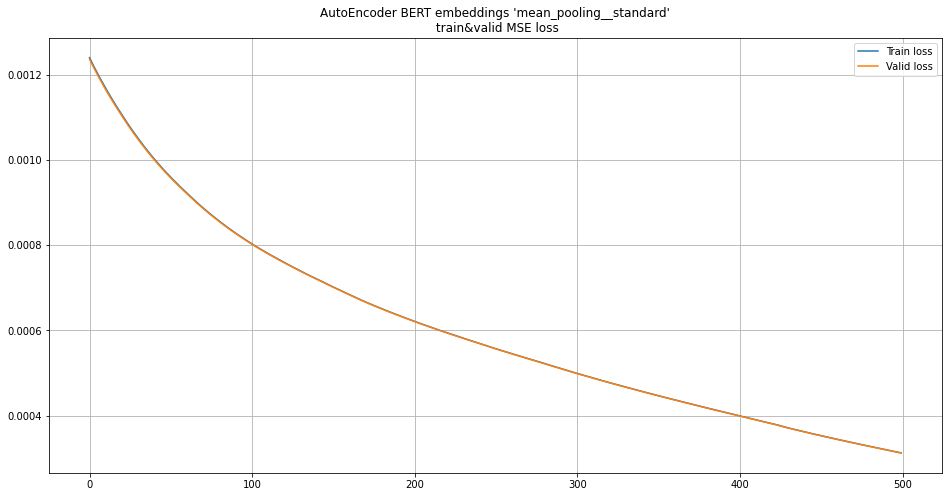

In [35]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

optimizer = Adam(model.parameters(), lr=1e-7, )
scheduler = StepLR(optimizer, step_size=100, gamma=.1) 

# torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 6),
    # save_best_params_as = './ae_weights/bertemb_train_5.pt',
    title="AutoEncoder BERT embeddings 'mean_pooling__standard'\n train&valid MSE"
)

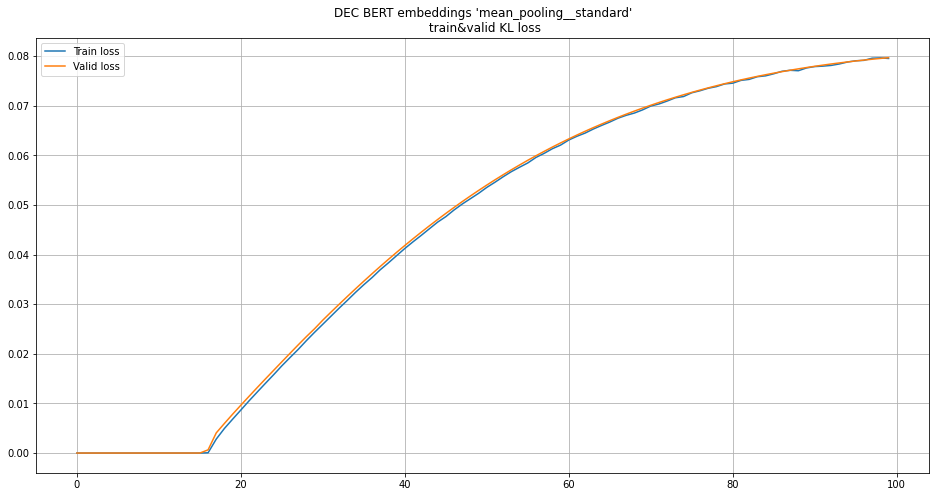

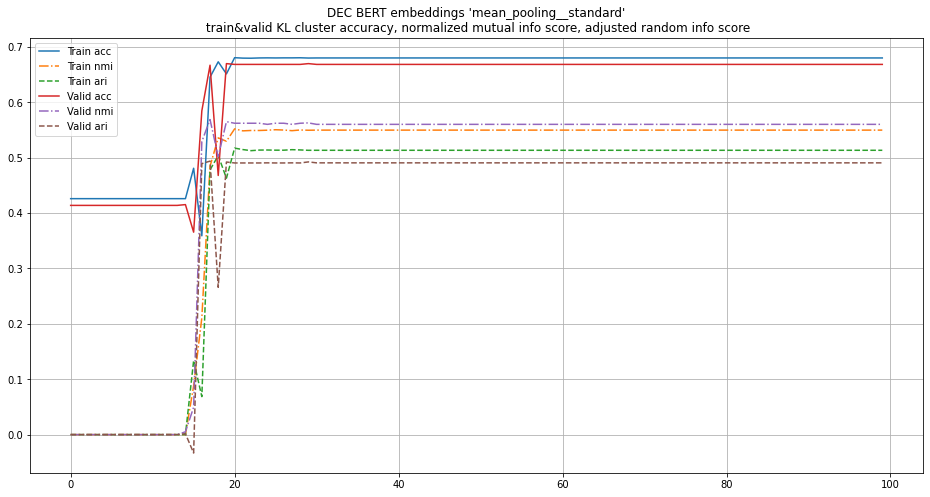

In [37]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_5.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    # patience_threshold = (10,4),
    device = device,
    # save_best_params_as='./weights/bertemb_dec_weights_5.pt',
    title="DEC BERT embeddings 'mean_pooling__standard'\n train&valid KL"
)


In [38]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.24414556962025316 0.6821870995301154


*Again we obtain strange behavior of learning curve - yet with bad initial guess model managed to reach stable clustering accuracy which beats baseline. Don't think it is good to validate unsupervise clustering on such strange learning curve*

#### num. 6 'mean_pooling__layer'

In [8]:
embeddings = torch.Tensor(embdict['mean_pooling__layer'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

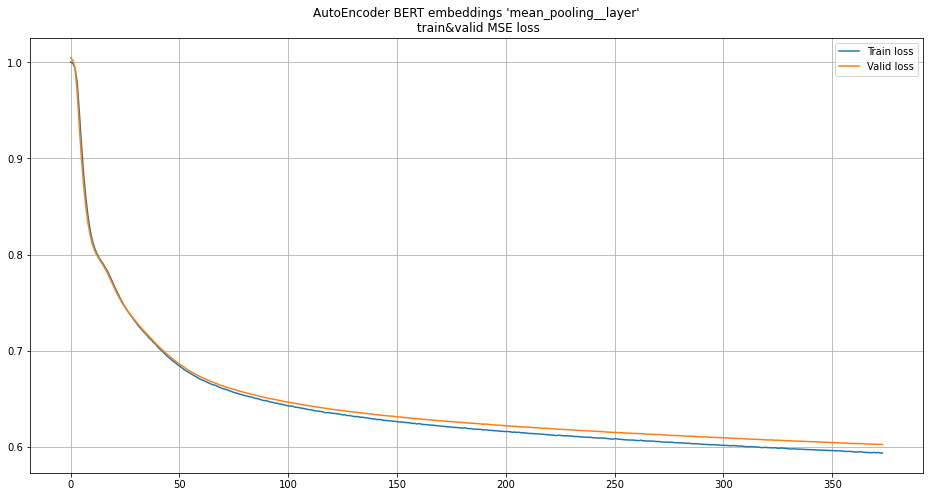

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 60.47it/s]

patience: 9
Training stopped. Patience threshold was reached


In [40]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.00)

optimizer = Adam(model.parameters(), lr=1e-5, )
# scheduler = StepLR(optimizer, step_size=100, gamma=10) 


whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 3),
    # save_best_params_as = './ae_weights/bertemb_train_6.pt',
    title="AutoEncoder BERT embeddings 'mean_pooling__layer'\n train&valid MSE"
)

##### DEC

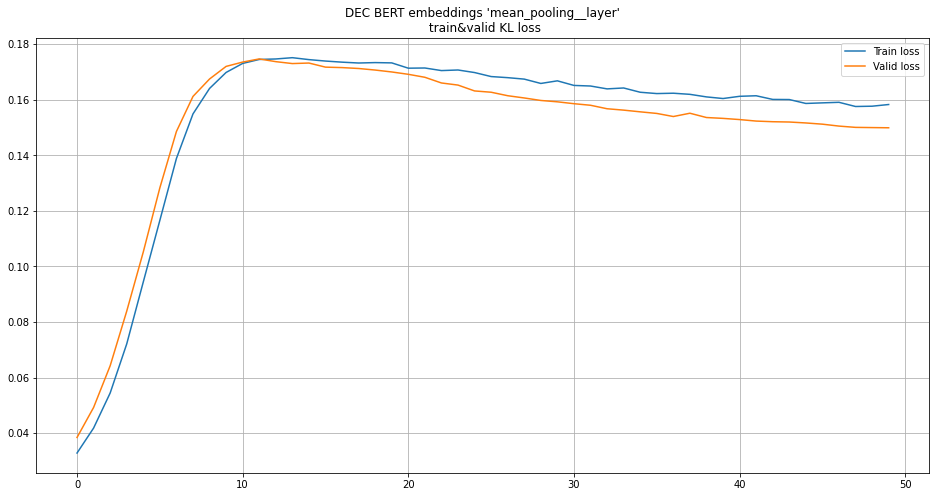

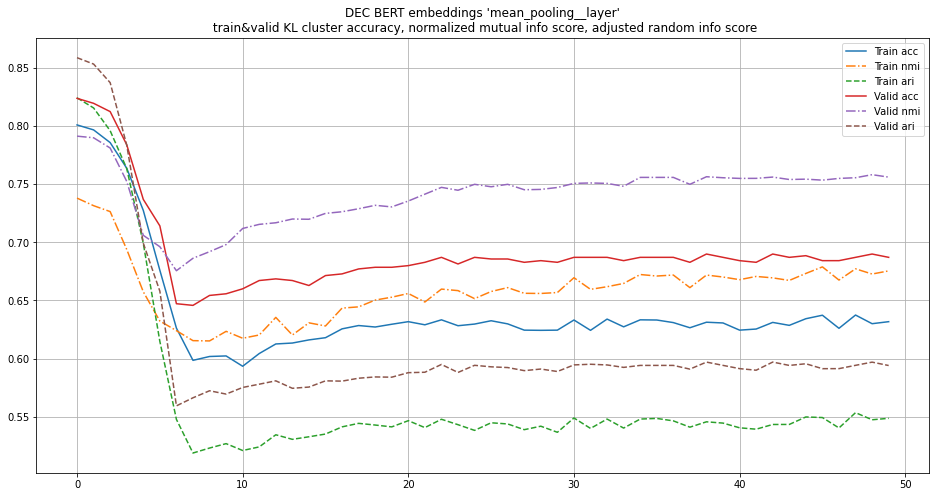

In [9]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.05)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_6.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-5)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 50,
    # patience_threshold = (10,4),
    device = device,
    # save_best_params_as='./weights/bertemb_dec_weights_6.pt',
    title="DEC BERT embeddings 'mean_pooling__layer'\n train&valid KL"
)


In [10]:
dec.load_state_dict(torch.load('./weights/bertemb_dec_weights_6.pt'))

print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.5670886075949367 0.8106222412074612


Cool! We managed to get great clustering performance by saving weights with the best loss. Yet the behavior of KLdiv loss is not very predictable, but the clue to the good cluster accuracy is smooth and moderate learning curve.

In [31]:
full_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=-1)

full_loader = DataLoader(
    full_dataset,
    batch_size=256, shuffle=False, num_workers=0, pin_memory=True
)
results = predict_cluster_accuracy(dec, full_loader, device, reassigned=True)
results

Evaluate cluster accuracy: 100%|██████████| 28/28 [00:02<00:00, 13.83it/s]


{'accuracy': 0.8106222412074612,
 'predicted': array([0, 0, 0, ..., 3, 3, 3], dtype=int64),
 'features': array([[0.12356635, 0.21763717, 0.09900541, ..., 0.16925225, 0.15586992,
         0.1138969 ],
        [0.10370163, 0.24242695, 0.08966699, ..., 0.17840114, 0.16797696,
         0.10854487],
        [0.1357603 , 0.22922027, 0.09135342, ..., 0.16517475, 0.15275496,
         0.10683195],
        ...,
        [0.13122916, 0.07927558, 0.24481429, ..., 0.08933486, 0.10079198,
         0.17858191],
        [0.11412184, 0.09570916, 0.21587217, ..., 0.11226915, 0.12785417,
         0.18352073],
        [0.1060904 , 0.09264331, 0.22063494, ..., 0.1197267 , 0.12278406,
         0.18623072]], dtype=float32)}

In [34]:
np.save('./predictions/dec_results_dict.npy', results)
np.save('./predictions/dec_textcluster.npy', full_dataset.get_text_by_labels(results['predicted']) )

*Much better! The only problem is that DEC (and hence IDEC) accuracy degrades - it is possibly connected with not stable local minimum area. From the other hand, DEC efficiency was prooved on the MNIST dataset, which is well-balanced dataset with n=70000 samples, while our embeddings dataset has n=7023 unbalanced samples. Hypothesis: we can try get an additional performance by augmenting our dataset*

# Dataset Augmentation

First of all, we should get a clear picture of what we want to get from our augmentation. In practice of unsupervised learning:
- We do not know which sample correlates to which class *a priori*
- But we do have initial guess of how many KMeans clusters do we have (n_clusters=7)
- To augment samples we can use backtranslation technique

*See DatasetAugmentation.ipynb for details*